## Data Generation
Author: Allen Ross  
Date: 05/13/21   
In this notebook we will be generating some data from known kernels to test kernel learning methods.

In [1]:
# Libraries
import gpflow
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from gpflow.utilities import print_summary

# Figure options
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
mpl.rcParams['axes.linewidth'] = 0.25
# set tick width
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = .5
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.width'] = .25
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = .5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.width'] = .25

Generate X design matrix

In [2]:
## Specify data generating parameters
# Set seed for reproducibility
np.random.seed(9012)

# Number of individual units
num_units = 10

# Assign treatment group to each unit
treat_group = np.repeat([0,1], num_units/2)
# treat_group = np.random.binomial(n=1, p=0.6, size=num_units)

# Sample number of observations for each unit
num_obs = np.random.poisson(lam=12, size=num_units)

# Sample from uniform distribution for observation times
x = np.concatenate(
    [np.sort(np.round(np.random.uniform(low=0, high=12, size=i),1)) for i in num_obs],
    axis=0)

# Put unit ID and observation time together
df = np.array([np.repeat(np.arange(num_units), num_obs),
               np.repeat(treat_group, num_obs),
               x]).T
print('Size of observation set:', df.shape)
df[:5,]

Size of observation set: (117, 3)


array([[0. , 0. , 2.5],
       [0. , 0. , 5.1],
       [0. , 0. , 5.5],
       [0. , 0. , 6.1],
       [0. , 0. , 6.8]])

In [3]:
# Create range for simulated set as well
sim_x = np.arange(start=0, stop=12, step=0.1)
df_sim = np.hstack((np.repeat(np.arange(num_units), len(sim_x))[:, None],
               np.repeat(treat_group, len(sim_x))[:, None],
               np.tile(np.round(sim_x,2), reps=num_units)[:, None]))

# Get proper index of observed rows
obs_idx = (np.concatenate([np.where((df_sim == df[i,:]).sum(axis=1) == 3) 
                           for i in range(df.shape[0])]).flatten())

print('Size of simulation set:', df_sim.shape)
df_sim[:5,]

Size of simulation set: (1200, 3)


array([[0. , 0. , 0. ],
       [0. , 0. , 0.1],
       [0. , 0. , 0.2],
       [0. , 0. , 0.3],
       [0. , 0. , 0.4]])

### Kernels

#### Kernel 1: individual offset + matern32 over time
This kernel represents a biological process that has differening individual levels, but across individuals there is a conserved dynamic process occuring. An example of what this might represent is a metabolite that is tied to specific time-dependent events that are similar across individuals (e.g. holidays or large gatherings might produce these effects).

#### Kernel 2: individual offset + individual * squaredexp over time + periodic over time
This kernel represents a biological process that also has differing individual level offsets, individual-specific time components, and an overall periodic process occuring across all individuals. This might represent a metabolite that has a seasonal effect but also depends on a particular individuals behaviors and habits over time. 

#### Kernel 3: individual offset + linear treatment effect
This kernel represents a linear treatment effect over time, where each individual has a different baseline value. This might represent a particular metabolite value that differs by person, but also is affected by a given treatment over time. 

#### Kernel 4: individual offset + polynomial treatment effect + individual * matern32 over time
This kernel represents a nonlinear treatment effect but it is also confounded by the fact that the feature is also changing naturally over time.

In [4]:
## Specify kernels
# First kernel is just a simple time varying covariance structure + unit offset
k1 = (gpflow.kernels.Matern32(variance=1.0, lengthscales=1.0, active_dims=[2]) + 
     gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]))
#

# Second kernel is random unit specfic effect + time varying unit specific effect + 
# periodic overall effect
k2 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
     gpflow.kernels.SquaredExponential(variance=1.0, lengthscales=1.0, active_dims=[2]) * 
     gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
     gpflow.kernels.Periodic(
         base_kernel=gpflow.kernels.SquaredExponential(
             variance=1.0, active_dims=[2]),
         period=3.0))

# Third kernel is random unit specific effect + treatment effect
k3 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
      gpflow.kernels.Coregion(output_dim=len(np.unique(treat_group)), rank=1, active_dims=[1]) * 
      gpflow.kernels.Linear(variance=0.1, active_dims=[2]))

# Fourth kernel is unit specific effect + changepoint (M32/M32)
# k4 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
#       gpflow.kernels.ChangePoints(kernels = [gpflow.kernels.Matern32(variance=5.0,lengthscales=0.5,active_dims=[2]),
#                                              gpflow.kernels.Matern32(variance=1.0,lengthscales=2.5,active_dims=[2])],
#                                   locations = [3],
#                                   steepness=1.0))
## Can't use changepoint model at the moment, as GPflow doesn't allow for multidimension CP kernels

# Fourth kernel is random unit effect + nonlinear random treatment effect over time + 
# nonlinear individual effect over time
k4 = (gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) + 
      gpflow.kernels.Coregion(output_dim=len(np.unique(treat_group)), rank=1, active_dims=[1]) * 
      gpflow.kernels.Polynomial(degree = 2, offset = 0.05, variance=0.05, active_dims=[2]) + 
#       gpflow.kernels.Linear(active_dims=[2]) + 
      gpflow.kernels.Coregion(output_dim=num_units, rank=1, active_dims=[0]) *
      gpflow.kernels.Matern32(variance=1.0, lengthscales=3.0, active_dims=[2]))


# Kernel dictonary
kern_out = {'k1': {'model': k1},
            'k2': {'model': k2},
            'k3': {'model': k3},
            'k4': {'model': k4}}

Sampling from kernel k1
Sampling from kernel k2
Sampling from kernel k3
Sampling from kernel k4


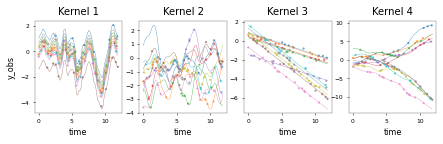

In [5]:
np.random.seed(9012)
# Specify plot object
f, axs = plt.subplots(1, len(kern_out), figsize=(7.2,1.7))
ic = 0
# Prepare data for plotting
df_plot = pd.DataFrame(df, 
                       columns=['unit','treatment','time'])
df_plot.unit = df_plot.unit.astype('category')
df_sim_plot = pd.DataFrame(df_sim, 
                       columns=['unit','treatment','time'])
df_sim_plot.unit = df_sim_plot.unit.astype('category')

# Sample from kernels
for k in kern_out.keys():
    print('Sampling from kernel {}'.format(k))
    kern_out[k]['f_true'] = np.random.multivariate_normal(
        np.zeros_like(df_sim[:,0]).flatten(),
        kern_out[k]['model'](df_sim),# + 1e-4*np.eye(df_sim.shape[0]),
        1
    )
    
    kern_out[k]['y_obs'] = (kern_out[k]['f_true'][0,obs_idx] + 
                            np.random.normal(scale=0.1, size=len(df)))
    
    # Plot resulting output
    df_sim_plot = df_sim_plot.assign(f_true = kern_out[k]['f_true'].flatten())
    df_plot = df_plot.assign(y_obs = kern_out[k]['y_obs'].flatten())
    p = sns.scatterplot(data=df_plot,
                        x='time',
                        y='y_obs',
                        hue='unit',
                        linewidths = 0.05,
                        s=5,
                        alpha=0.7,
                        legend=False,
                        ax=axs[ic])
    p = sns.lineplot(data=df_sim_plot,
                     x='time',
                     y='f_true',
                     hue='unit',
                     legend=False,
                     alpha=0.9,
                     linewidth=0.35,
                     ax=axs[ic])
    p.set_title('Kernel {}'.format(ic+1))
    if ic != 0:
        p.set_ylabel('')
    p.plot();
    
    ic += 1
    
# f_true = np.random.multivariate_normal(
#     np.zeros_like(df[:,0]).flatten(),
#     k1(df),
#     1
# )
# y_true = f_true + np.random.normal(scale=1)

# for i in range(num_units):
# #     plt.plot(x, y_true[i,:], 'x')
#     plt.plot(x, y_true[i,:], 'b')

# plt.plot(df[:,2], f_true.T, 'x')
# plt.plot(x, y_true.T);

In [6]:
plt.tight_layout()
f.savefig('../figures/kernels.pdf', dpi=350, bbox_inches = "tight") 
f.savefig('../figures/Kernels.png', dpi=350, bbox_inches = "tight")
plt.close()

In [7]:
# Drop plotting column
df_plot.drop(columns=['y_obs'], inplace=True)
for k in kern_out.keys():
    df_plot[k+'_obs'] = np.round(kern_out[k]['y_obs'], 2)
df_plot.head()

,unit,treatment,time,k1_obs,k2_obs,k3_obs,k4_obs
0,0.0,0.0,2.5,1.22,-0.08,0.22,0.92
1,0.0,0.0,5.1,1.05,-0.61,-0.15,1.52
2,0.0,0.0,5.5,-0.01,-0.85,-0.36,1.41
3,0.0,0.0,6.1,-0.79,-0.17,-0.49,2.20
4,0.0,0.0,6.8,0.51,-0.06,-0.70,2.60


In [8]:
# Save output data
df_plot.to_csv('simulated_data.csv', index=False)

In [9]:
# Calculate best BIC from known models
def calc_bic(loglik, n, k):
    return k*np.log(n)-2*loglik

from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([1,0])

0.09653235263005393

In [10]:
from scipy.stats import multivariate_normal
mvn = multivariate_normal(
    mean = np.zeros_like(df[:,0]), 
    cov = k1(df) + 0.01*np.eye(df.shape[0])
)
k1_loglik = mvn.logpdf(df_plot['k1_obs'])
calc_bic(k1_loglik, n=df.shape[0], k=len(k1.trainable_parameters))

44.67663031291681